In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Activation
from keras.models import Model
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Exercício 1
**Objetivo: retomar o classificador logístico**

Até o momento, usamos a regressão logística como método para classificação.

Com suas palavras, discuta: o que cada etapa da pipeline de classificação abaixo faz?

In [3]:
df = pd.read_csv('datasets/IMDB Dataset.csv').sample(1000)
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'])

In [4]:
classificador = Pipeline([
                        ('meu_vetorizador', CountVectorizer(stop_words='english', binary=True, max_features=500)),
                        ('meu_classificador', LogisticRegression(penalty=None, solver='saga', max_iter=10000))
                        ])
classificador.fit(X_train,y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred,y_test)
print(acc)

0.764


# Exercício 2
*Objetivo: implementar o regressor logístico usando Keras*

O regressor logístico, para diferenciar entre duas classes, faz o seguinte processo:

1. Uma das classes é associada à saída 1, e a outra é associada à saída -1
1. O classificador recebe como entrada um vetor-coluna $x$
1. A entrada é multiplicada por um vetor de pesos e depois somada a um *bias*, gerando $y_1 = x^T w + b$
1. A função $\tanh()$ é aplicada a $y_1$, gerando a saída $\hat{y} = \tanh(y_1)$

Quando estamos *treinando* o regressor logístico (na chamada `.fit()`), ajustamos os pesos $w$ para que o erro quadrático médio seja reduzido em um conjunto de treinamento.

Vamos implementar essa mesma sequência usando Keras, isto é, vamos executar uma pequena rede neural para fazer essa mesma tarefa.

No código abaixo, identifique as partes correspondentes a cada uma dessas etapas.

In [5]:
def pre_processar_saidas(y):
    y_out = np.zeros_like(y)
    y_out[ y=='negative' ] = -1.0
    y_out[ y=='positive' ] = 1.0
    y_out = y_out.reshape( (-1, 1))
    return y_out.astype(float)

y_train_ = pre_processar_saidas(y_train)
y_test_ = pre_processar_saidas(y_test)

vectorizer = CountVectorizer(stop_words='english', binary=True, max_features=500)
X_train_ = vectorizer.fit_transform(X_train).todense().astype(float)
X_test_ = vectorizer.transform(X_test).todense().astype(float)

In [6]:
def base_model(vocab_size=500):
    input_layer = Input(shape=(vocab_size,))
    x = input_layer
    x = Dense(1, name='classificador')(x)
    x = Activation('tanh')(x)
    return Model(input_layer, x)

clf = base_model()
clf.compile(loss='mean_squared_error', metrics=['accuracy'])
clf.fit(X_train_, y_train_, epochs=5, verbose=1)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/5


2023-04-11 12:33:26.855960: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


24/24 [==============================] - 1s 10ms/step - loss: 1.0795 - accuracy: 0.0307
Epoch 2/5
24/24 [==============================] - 0s 5ms/step - loss: 0.9692 - accuracy: 0.0440
Epoch 3/5
24/24 [==============================] - 0s 5ms/step - loss: 0.8887 - accuracy: 0.0507
Epoch 4/5
24/24 [==============================] - 0s 5ms/step - loss: 0.8176 - accuracy: 0.0680
Epoch 5/5
24/24 [==============================] - 0s 5ms/step - loss: 0.7541 - accuracy: 0.0720


In [7]:
acc = clf.evaluate(X_test_, y_test_)
print(acc)

8/8 [==============================] - 0s 6ms/step - loss: 0.7788 - accuracy: 0.1000
[0.778777003288269, 0.10000000149011612]


In [8]:
y_pred = clf.predict(X_test_)
#print(y_pred.T)

8/8 [==============================] - 0s 2ms/step


# Exercício 3
**Objetivo: visualizar parâmetros da rede neural**

À partir do código abaixo, responda:

1. Quantos parâmetros a rede neural tem? O que eles representam?
1. Como podemos acessar os pesos de uma camada da rede?

In [9]:
print(clf.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 classificador (Dense)       (None, 1)                 501       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
print(clf.get_layer('classificador').weights[0].shape)
print(clf.get_layer('classificador').weights[1].shape)

(500, 1)
(1,)


# Exercício 4
*Objetivo: monitorar o erro de treinamento e de validação em um treinamento de rede*

Usualmente, o que vemos em redes neurais é que o erro em relação ao conjunto de treino cai, ao passo que o erro em relação ao conjunto de teste tende a subir. Por isso, em geral separamos uma parte do conjunto de treino a chamamos de "validação". Daí, monitoramos o erro no conjunto de validação.

O pacotre `keras` nos permite monitorar ambos os erros (treino e validação) através do objeto `history`, que é retornado pelo método `.fit()`.

1. O que significa cada um dos painéis gerados pelo código abaixo? Adicione o `plt.xlabel` e `plt.ylabel` para completar os paineis.
1. Aumente o número de épocas de treinamento para 100. Como os erros monitorados se comportam?


In [11]:
clf = base_model()
clf.compile(loss='mean_squared_error', metrics=['accuracy'])
history = clf.fit(X_train_, y_train_, epochs=5, verbose=1, validation_split=0.1)


Epoch 1/5
22/22 [==============================] - 1s 18ms/step - loss: 1.0284 - accuracy: 0.0341 - val_loss: 0.9684 - val_accuracy: 0.0400
Epoch 2/5
22/22 [==============================] - 0s 8ms/step - loss: 0.9298 - accuracy: 0.0415 - val_loss: 0.9230 - val_accuracy: 0.0400
Epoch 3/5
22/22 [==============================] - 0s 7ms/step - loss: 0.8656 - accuracy: 0.0533 - val_loss: 0.8888 - val_accuracy: 0.0400
Epoch 4/5
22/22 [==============================] - 0s 7ms/step - loss: 0.8060 - accuracy: 0.0622 - val_loss: 0.8689 - val_accuracy: 0.0800
Epoch 5/5
22/22 [==============================] - 0s 7ms/step - loss: 0.7515 - accuracy: 0.0815 - val_loss: 0.8430 - val_accuracy: 0.1067


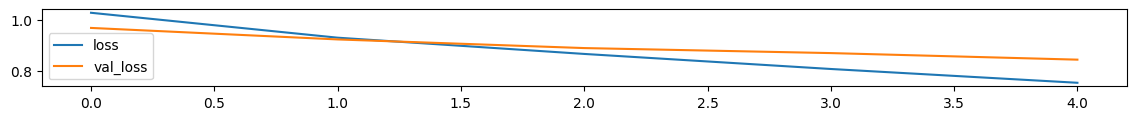

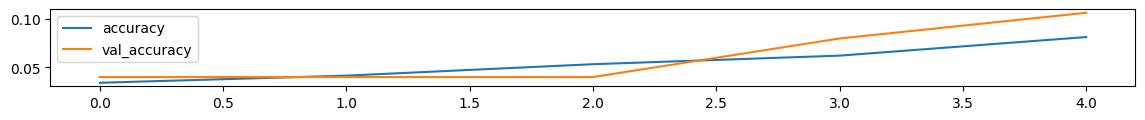

In [12]:
plt.figure(figsize=(14,1))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.figure(figsize=(14,1))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


# Exercício 5
*Objetivo: usar a representação one-hot para as saídas da rede*

Até este momento, estamos minimizando o EQM entre a saída predita e a saída "correta" de nossa base de dados. O EQM parece estar ligado ao erro de predição, mas só até um certo limite. Vamos agora testar outra ideia.

As saídas da nossa rede serão tantas quantas as classes de nosso conjunto. Cada uma das saídas representará a probabilidade da entrada pertencer à classe correspondente, isto é, a saída $n$ significa:

$$
P(C_n | x)
$$

Para isso, vamos fazer as seguintes alterações na nossa rede:

1. Teremos duas saída, e não mais uma única saída,
1. A ativação que utilizaremos será a função `softmax`, que essencialmente força a saída a ter soma 1 ao longo de todas as probabilidades preditas,
1. A função de *loss* será a entropia cruzada categórica, que significa que estamos minimizando a probabilidade de erro (e não mais o EQM)

Como consequência, precisamos pré-processar nossos rótulos de forma que eles fiquem numa representação one-hot. Keras não nos dá um objeto para lidar com isso, mas sklearn sim:


In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
y_train_ = ohe.fit_transform(y_train.to_numpy().reshape((-1,1))).todense()
y_test_ = ohe.transform(y_test.to_numpy().reshape((-1,1))).todense()

O código abaixo realiza o treinamento da rede usando a função softmax e a categorical cross-entropy como medida de erro.

1. Verifique quantos parâmetros existem na nova rede. O que esses parâmetros significam?
1. Adicione código para monitorar o histórico do loss e do accuracy no conjunto de validação, e treine a rede por 50 épocas.
1. Após, use o método `.evaluate` para avaliar a rede num conjunto de teste.
1. Compare o desempenho deste modelo com o do regressor logístico que foi feito no começo da aula.

In [ ]:
def softmax_model(vocab_size=500):
    input_layer = Input(shape=(vocab_size,))
    x = input_layer
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

clf = softmax_model()
print(clf.summary())
clf.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf.fit(X_train_, y_train_, epochs=5, verbose=1) # validation_split=0.1
# clf.evaluate(X_test_, y_test_)

# Exercício 6
**Objetivo: investigar e interpretar os pesos da rede neural**

A camada densa da rede neural recebe como entrada um vetor-coluna $x$, aplica um vetor-coluna de pesos $w$ e depois soma um bias $b$, retornando $x^T w + b$.

Em nossa rede neural, o vetor de pesos tem 2 colunas:

In [ ]:
print(clf.get_layer('classificador').weights[0].shape)

1. Por que esse vetor de pesos tem duas colunas?
1. Qual é o significado de um peso que está na linha $i$ e na coluna $j$?
1. Use o código abaixo para identificar o que a rede, na configuração atual, está "olhando" para realizar a classificação. Quais palavras mais tipicamente aparecem em reviews "positivos"? Quais palavras mais tipicamente aparecem em reviews "negativos"?

In [ ]:
from tqdm import tqdm
weights = clf.get_layer('classificador').weights[0].numpy()
CLASSE = 0
for n in tqdm(range(len(vectorizer.vocabulary_))):
    tuplas = [ (weights[vectorizer.vocabulary_[i],CLASSE], i) for i in vectorizer.vocabulary_.keys() ]
    tuplas_ordenadas = sorted(tuplas, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
    palavras = [ t[1] for t in tuplas_ordenadas ]
    contagens = [ t[0] for t in tuplas_ordenadas ]


In [ ]:
n_palavras = 20

plt.figure(figsize=(14,1))
eixo_x = np.arange(n_palavras)
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.title("Peso das palavras")
plt.show()

# Exercício 7
*Objetivo: fazer um classificador de spam usando rede neural*

Usando as estratégias que vimos até o momento, faça um classificador de spam para o spam/ham dataset, mostre suas curvas de aprendizado (treino e validação) e avalie o accuracy do resultado final em um conjunto de treino.